In [7]:
%pip install joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# from sklearn.externals import joblib
import joblib

warnings.filterwarnings('ignore')

[STATUS] features shape: (60, 532)
[STATUS] labels shape: (60,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (54, 532)
Test data   : (6, 532)
Train labels: (54,)
Test labels : (6,)
LR: 0.556667 (0.270822)
LDA: 0.543333 (0.280099)
KNN: 0.540000 (0.204831)
CART: 0.516667 (0.196780)
RF: 0.590000 (0.229032)
NB: 0.493333 (0.150407)
SVM: 0.443333 (0.164688)


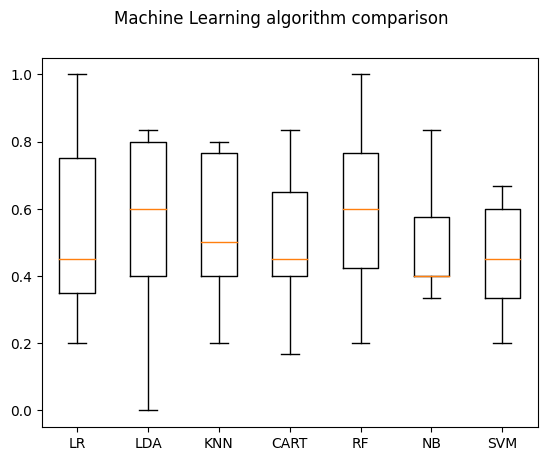

In [9]:

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [10]:
from myglobal import fixed_size
from myglobal import fd_hu_moments
from myglobal import fd_haralick
from myglobal import fd_histogram

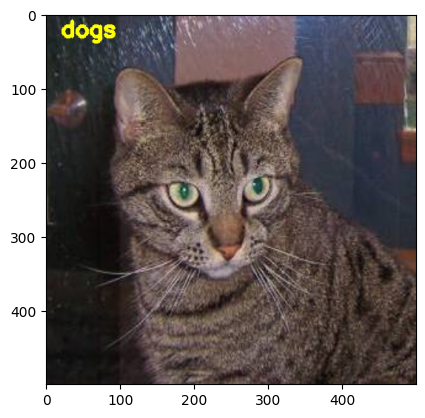

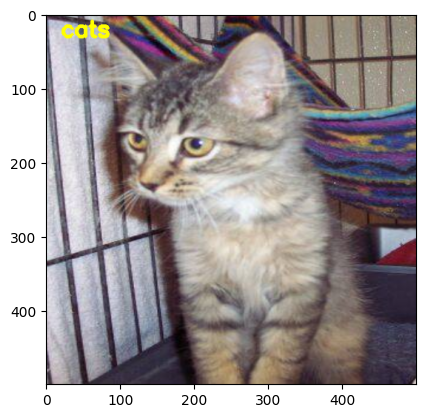

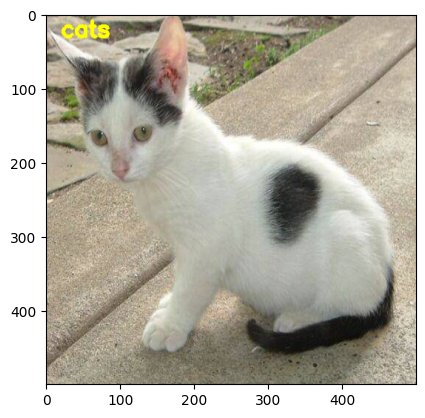

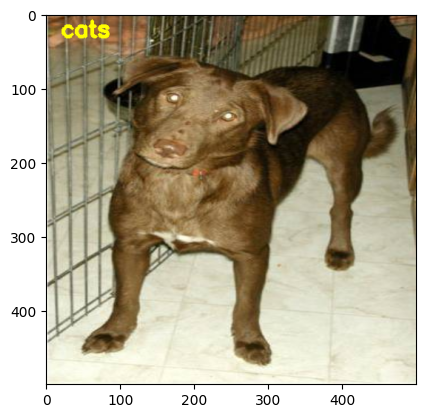

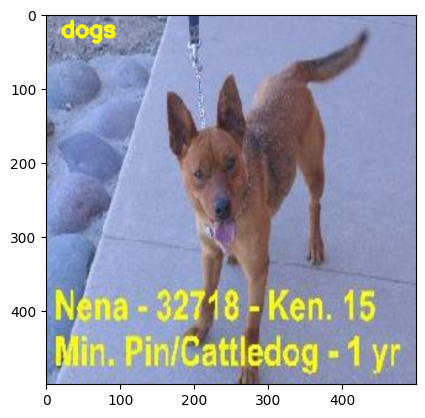

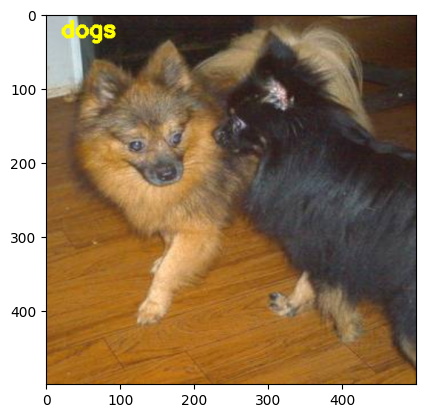

In [11]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)
    # image = cv2.imread(dataset/)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature.reshape(-1, 1))

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [12]:
# # Import necessary libraries
# import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score
# import seaborn as sns

# def extract_true_label_from_filename(true_file):
#     # Assuming the label is the first part of the filename
#     true_file = 'output/labels.h5'
#     label = os.path.basename(true_file).split('_')[0]
#     return label


# # Initialize variables to store true labels and predicted labels
# true_labels = []
# predicted_labels = []

# # Loop through the test images
# for file in glob.glob(test_path + "/*.jpg"):
#     # (Your existing code for feature extraction and prediction)

#     # Append true label to the list
#     true_label = extract_true_label_from_filename(file)  # You need to implement a function to extract the true label from the filename
#     true_labels.append(true_label)

#     # Append predicted label to the list
#     predicted_labels.append(train_labels[prediction])

# # Convert lists to numpy arrays
# true_labels = np.array(true_labels)
# predicted_labels = np.array(predicted_labels)

# # Create confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# # Print confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Visualize confusion matrix using seaborn
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_labels, yticklabels=train_labels)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()